In [1]:
##Question 4

from sklearn.datasets import load_boston
from statistics import mean
import pandas as pd
import random
from math import sqrt,exp,pi
import numpy as np
from numpy.linalg import inv, det

random_seed = 33

In [2]:
def feature_rand_select(num, dataframe):
    return dataframe.sample(n=num,axis='columns', random_state=random_seed)

def split_data(boston_dataset, num):
    df = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
    #print(df.keys())
    df = df.drop(columns=['ZN', 'INDUS', 'CHAS', 'DIS', 'RAD','PTRATIO', 'B','TAX', 'AGE'])
    df = feature_rand_select(num, df)
    df['target'] = boston_dataset.target
    df['label'] = -1
    mean = np.mean(boston_dataset['target'])
    for index, data in df.iterrows():
        if data['target'] >= mean:
            df.loc[index, 'label'] = 1 ##1=high 
        else:
            df.loc[index, 'label'] = 0 ##0=low
    data = df.drop(columns='target')
    test = data.sample(frac = 0.3, random_state = random_seed)
    train = data.drop(test.index, axis=0)
    test.reset_index(inplace=True, drop=True)
    train.reset_index(inplace=True, drop=True)
    return train, test, mean

In [3]:
def group_train(train_data):
    groups = train_data.groupby('label')
    return groups.get_group(1), groups.get_group(0)

def get_empty_parameters(train_data):
    para1, para0 = pd.DataFrame(columns = train_data.keys()),  pd.DataFrame(columns = train_data.keys())
    para1 = para1.drop(columns='label')
    para0 = para0.drop(columns='label')
    return para1, para0

In [4]:
def mean_n_beta(numbers):
        mu = np.mean(numbers)
        variance = sum([(x-mu)**2 for x in numbers])/ float(len(numbers))
        return mu, sqrt(variance)/sqrt(2)

def train_parameters(train_data, para1, para0, group1, group0):
    empty_row = [None]*(train_data.shape[1]-1)
    para1.loc[para1.shape[0]] = empty_row
    para1.loc[para1.shape[0]] = empty_row
    for key in para1.keys():
        para1[key][0], para1[key][1] = mean_n_beta(group1[key])        
    para0.loc[para0.shape[0]] = empty_row
    para0.loc[para0.shape[0]] = empty_row
    for key in para0.keys():
        para0[key][0], para0[key][1] = mean_n_beta(group0[key])
    

In [5]:
def prob_laplace(x, mu, beta):
    exponent = exp(-abs(x-mu)/beta)
    return 1/(2*beta)*exponent

def get_prior(train, group1, group0):
    return len(group1)/len(train), len(group0)/len(train)

def predict(test_data, prior1, prior0, para1, para0):
    test_data['pred'] = ""
    for idx, row in test_data.iterrows():
        if idx == (test_data.shape[1]-1):
            continue
        prob1, prob0 = prior1, prior0
        for i in range(len(para1)):
            prob1 *= prob_laplace(row[i], para1.iloc[0][i], para1.iloc[1][i])
            prob0 *= prob_laplace(row[i], para0.iloc[0][i], para0.iloc[1][i])
        if prob1 > prob0:
            test_data.loc[idx, 'pred'] = 1
        else:
            test_data.loc[idx, 'pred'] = 0
            
def get_accuracy(test_data):
    hit = 0
    for idx, row in test_data.iterrows():
        if row['pred']==row['label']:
            hit+=1
    return hit/len(test_data)

def gaussian_probability(x, mean, stdev):
        exponent = exp(-((x-mean)**2 / (2 * stdev**2 )))
        return (1 / (sqrt(2 * pi) * stdev)) * exponent

def cal_std(data):
    mu = np.mean(data)
    variance = sum([(x-mu)**2 for x in data])/ float(len(data))
    return sqrt(variance)    
    
def cal_shared_std(data1, data0):
    data_combined = [data1, data0]
    data_combined = pd.concat(data_combined)
    #print(data_combined)
    mu = np.mean(data_combined)
    variance = sum([(x-mu)**2 for x in data_combined])/ float(len(data_combined))
    return sqrt(variance)

def update_para_var(train_data, group1, group0, para1, para0):
    empty_row = [None]*(train_data.shape[1]-1)
    para1.loc[para1.shape[0]] = empty_row
    para0.loc[para0.shape[0]] = empty_row
    for key in para1.keys():
        para1[key][2] = cal_std(group1[key])  
        para0[key][2] = cal_std(group0[key])
        
def update_para_share_var(train_data, group1, group0, para1, para0):
    empty_row = [None]*(train_data.shape[1]-1)
    para1.loc[para1.shape[0]] = empty_row
    para0.loc[para0.shape[0]] = empty_row
    for key in para1.keys():
        para1[key][2] = cal_shared_std(group1[key], group0[key])        
        para0[key][2] = para1[key][2]
        
def predict_gaussian(test_data, prior1, prior0, para1, para0):
    #test_data['pred'] = ""
    for idx, row in test_data.iterrows():
        if idx == (test_data.shape[1]-1):
            continue
        prob1, prob0 = prior1, prior0
        for i in range(len(para1)):
            prob1 *= gaussian_probability(row[i], para1.iloc[0][i], para1.iloc[2][i])
            prob0 *= gaussian_probability(row[i], para0.iloc[0][i], para0.iloc[2][i])
        if prob1 > prob0:
            test_data.loc[idx, 'pred'] = 1
        else:
            test_data.loc[idx, 'pred'] = 0
            
##plotting functions
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def draw_scatter(df, Title):
    groups = df.groupby('pred')
    class1 = groups.get_group(1)
    class0 = groups.get_group(0)
    keys = class0.keys()
    plt.scatter(class1[keys[0]],class1[keys[1]],c="red", s = 15)
    plt.scatter(class0[keys[0]],class0[keys[1]],c="blue", s = 15)
    plt.xlabel(keys[0] + ' mean:' +"{:.2f}".format((np.mean(class0[keys[0]]+np.mean(class1[keys[0]])))/2))
    plt.ylabel(keys[1] + ' mean:' +"{:.2f}".format((np.mean(class0[keys[1]]+np.mean(class1[keys[1]])))/2))
    plt.title(Title, fontdict=None)
    plt.legend(['high', 'low'], numpoints=1, loc='upper left')
    plt.show()
def draw_scatter_truth(df, Title):
    groups = df.groupby('label')
    class1 = groups.get_group(1)
    class0 = groups.get_group(0)
    keys = class0.keys()
    plt.scatter(class1[keys[0]],class1[keys[1]],c="red", s = 15)
    plt.scatter(class0[keys[0]],class0[keys[1]],c="blue", s = 15)
    #newer_method_string = 
    plt.xlabel(keys[0] + ' mean:' +"{:.2f}".format((np.mean(class0[keys[0]]+np.mean(class1[keys[0]])))/2))
    plt.ylabel(keys[1] + ' mean:' +"{:.2f}".format((np.mean(class0[keys[1]]+np.mean(class1[keys[1]])))/2))
    plt.title(Title, fontdict=None)
    plt.legend(['high', 'low'], numpoints=1, loc='upper left')
    plt.show()    
from mpl_toolkits import mplot3d
def draw_scatter_truth_3d(df, Title):
    groups = df.groupby('label')
    class1 = groups.get_group(1)
    class0 = groups.get_group(0)
    keys = class0.keys()
    fig = plt.figure()
    # syntax for 3-D plotting
    ax = plt.axes(projection ='3d')
    ax.scatter(class1[keys[0]],class1[keys[1]], class1[keys[2]], c = 'red')
    ax.scatter(class0[keys[0]],class0[keys[1]], class0[keys[2]], c = 'blue')
    # syntax for plotting
    ax.set_xlabel(keys[0] + ' mean:' +"{:.2f}".format((np.mean(class0[keys[0]]+np.mean(class1[keys[0]])))/2))
    ax.set_ylabel(keys[1] + ' mean:' +"{:.2f}".format((np.mean(class0[keys[1]]+np.mean(class1[keys[1]])))/2))
    ax.set_zlabel(keys[2] + ' mean:' +"{:.2f}".format((np.mean(class0[keys[2]]+np.mean(class1[keys[2]])))/2))
    ax.set_title(Title)
    plt.show()
def draw_scatter_3d(df, Title):
    groups = df.groupby('pred')
    class1 = groups.get_group(1)
    class0 = groups.get_group(0)
    keys = class0.keys()
    fig = plt.figure()
    # syntax for 3-D plotting
    ax = plt.axes(projection ='3d')
    ax.scatter(class1[keys[0]],class1[keys[1]], class1[keys[2]], c = 'red', label="high")
    ax.scatter(class0[keys[0]],class0[keys[1]], class0[keys[2]], c = 'blue', label="low")
    # syntax for plotting
    ax.set_xlabel(keys[0] + ' mean:' +"{:.2f}".format((np.mean(class0[keys[0]]+np.mean(class1[keys[0]])))/2))
    ax.set_ylabel(keys[1] + ' mean:' +"{:.2f}".format((np.mean(class0[keys[1]]+np.mean(class1[keys[1]])))/2))
    ax.set_zlabel(keys[2] + ' mean:' +"{:.2f}".format((np.mean(class0[keys[2]]+np.mean(class1[keys[2]])))/2))
    ax.set_title(Title)
    plt.legend(loc="upper right")
    plt.show()

def draw_scatter_truth_3d_124(df, Title):
    groups = df.groupby('label')
    class1 = groups.get_group(1)
    class0 = groups.get_group(0)
    keys = class0.keys()
    fig = plt.figure()
    # syntax for 3-D plotting
    ax = plt.axes(projection ='3d')
    ax.scatter(class1[keys[0]],class1[keys[1]], class1[keys[3]], c = 'red')
    ax.scatter(class0[keys[0]],class0[keys[1]], class0[keys[3]], c = 'blue')
    # syntax for plotting
    ax.set_xlabel(keys[0] + ' mean:' +"{:.2f}".format((np.mean(class0[keys[0]]+np.mean(class1[keys[0]])))/2))
    ax.set_ylabel(keys[1] + ' mean:' +"{:.2f}".format((np.mean(class0[keys[1]]+np.mean(class1[keys[1]])))/2))
    ax.set_zlabel(keys[3] + ' mean:' +"{:.2f}".format((np.mean(class0[keys[3]]+np.mean(class1[keys[3]])))/2))
    ax.set_title(Title)
    plt.show()
def draw_scatter_3d_124(df, Title):
    groups = df.groupby('pred')
    class1 = groups.get_group(1)
    class0 = groups.get_group(0)
    keys = class0.keys()
    fig = plt.figure()
    # syntax for 3-D plotting
    ax = plt.axes(projection ='3d')
    ax.scatter(class1[keys[0]],class1[keys[1]], class1[keys[3]], c = 'red', label="high")
    ax.scatter(class0[keys[0]],class0[keys[1]], class0[keys[3]], c = 'blue', label="low")
    # syntax for plotting
    ax.set_xlabel(keys[0] + ' mean:' +"{:.2f}".format((np.mean(class0[keys[0]]+np.mean(class1[keys[0]])))/2))
    ax.set_ylabel(keys[1] + ' mean:' +"{:.2f}".format((np.mean(class0[keys[1]]+np.mean(class1[keys[1]])))/2))
    ax.set_zlabel(keys[3] + ' mean:' +"{:.2f}".format((np.mean(class0[keys[3]]+np.mean(class1[keys[3]])))/2))
    ax.set_title(Title)
    plt.legend(loc="upper right")
    plt.show()    

In [6]:
#def draw_train():

features: Index(['NOX', 'RM'], dtype='object')
accuracy using 2 random features:0.862


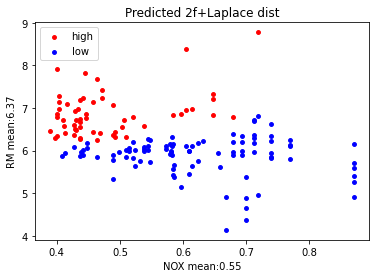

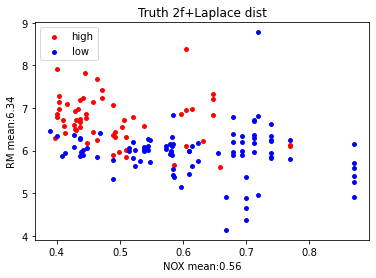

In [7]:
##4(a)
boston_dataset = load_boston()
##4(a) + 4(b)
train, test, mean = split_data(boston_dataset, 2)###4(a) split data, 2 for selecting 2 features
group1, group0 = group_train(train)
para1, para0 = get_empty_parameters(train)
print('features:' ,para1.keys())
train_parameters(train, para1, para0, group1, group0)
prior_1, prior_0 = get_prior(train, group1, group0)
predict(test, prior_1, prior_0, para1, para0)###4(b) prediction using 2 features
print('accuracy using 2 random features:%.3f'% get_accuracy(test))

##4(e) visualization the results
draw_scatter(test, 'Predicted 2f+Laplace dist')
draw_scatter_truth(test, 'Truth 2f+Laplace dist')

In [8]:

##4(c)
train_4, test_4, mean_4 = split_data(boston_dataset, 4)##4 for 4 features is defined here
group1_4, group0_4 = group_train(train_4)
para1_4, para0_4 = get_empty_parameters(train_4)
print('features:' ,para1_4.keys())
train_parameters(train_4, para1_4, para0_4, group1_4, group0_4)
prior_1_4, prior_0_4 = get_prior(train_4, group1_4, group0_4)
predict(test_4, prior_1_4, prior_1_4, para1_4, para0_4)###4(c) prediction using 4 features
print('accuracy using 4 random features:%.3f'% get_accuracy(test_4))


features: Index(['NOX', 'RM', 'LSTAT', 'CRIM'], dtype='object')
accuracy using 4 random features:0.849


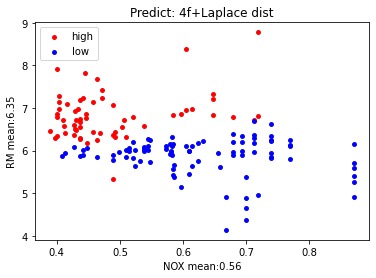

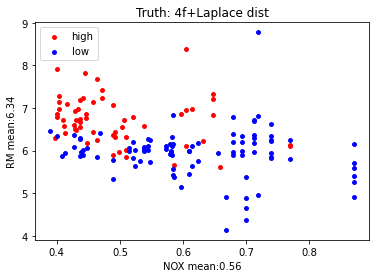

In [9]:
##4(e) visualization the results
draw_scatter(test_4, 'Predict: 4f+Laplace dist')
draw_scatter_truth(test_4, 'Truth: 4f+Laplace dist')

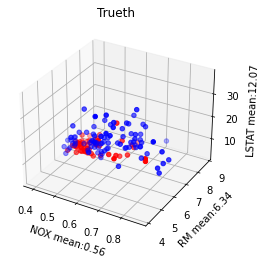

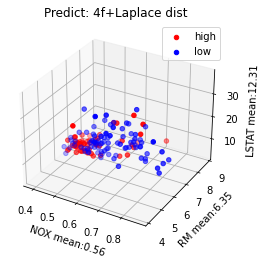

In [10]:
##4(e) visualization the results
draw_scatter_truth_3d(test_4, 'Trueth')
draw_scatter_3d(test_4, 'Predict: 4f+Laplace dist')

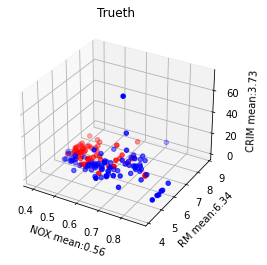

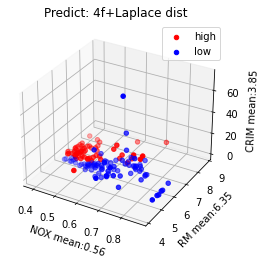

In [11]:
draw_scatter_truth_3d_124(test_4, 'Trueth')
draw_scatter_3d_124(test_4, 'Predict: 4f+Laplace dist')

In [12]:

##4(d) change trained parameters to shared std(=sqrt(variance))...reuse the data in 4(c)
update_para_share_var(train_4, group1_4, group0_4, para1_4, para0_4)
#update_para_var(train_4, group1_4, group0_4, para1_4, para0_4)
print('features:' ,para1_4.keys())
predict_gaussian(test_4, prior_1_4, prior_0_4, para1_4, para0_4)
print('accuracy using 4 previous features with Gaussian pdf and shared variance: %.3f'% get_accuracy(test_4))

features: Index(['NOX', 'RM', 'LSTAT', 'CRIM'], dtype='object')
accuracy using 4 previous features with Gaussian pdf and shared variance: 0.829


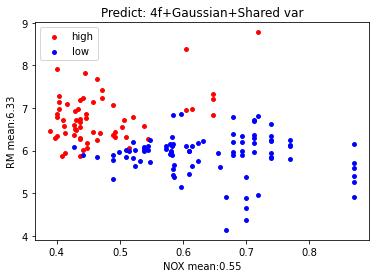

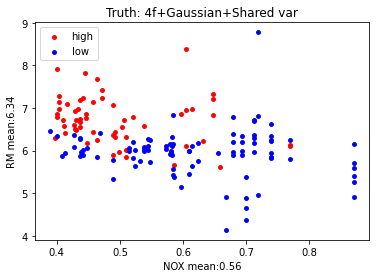

In [13]:
##4(e) visualization the results
draw_scatter(test_4, 'Predict: 4f+Gaussian+Shared var')
draw_scatter_truth(test_4, 'Truth: 4f+Gaussian+Shared var')

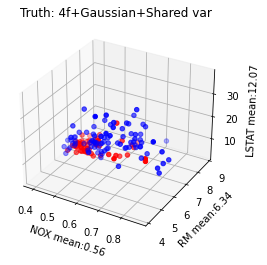

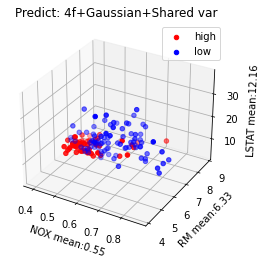

In [14]:
##4(e) visualization the results
draw_scatter_truth_3d(test_4, 'Truth: 4f+Gaussian+Shared var')
draw_scatter_3d(test_4, 'Predict: 4f+Gaussian+Shared var')

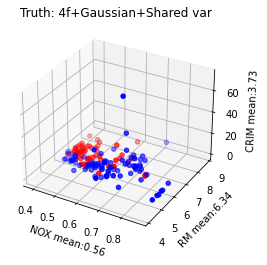

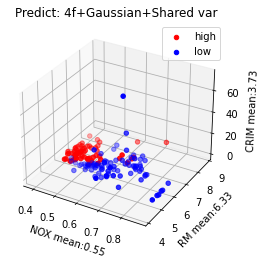

In [15]:
draw_scatter_truth_3d_124(test_4, 'Truth: 4f+Gaussian+Shared var')
draw_scatter_3d_124(test_4, 'Predict: 4f+Gaussian+Shared var')

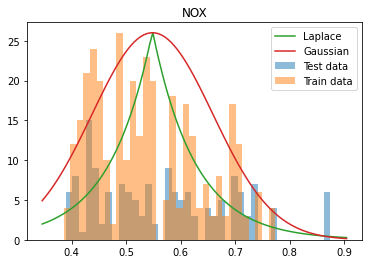

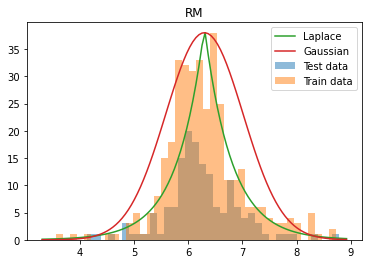

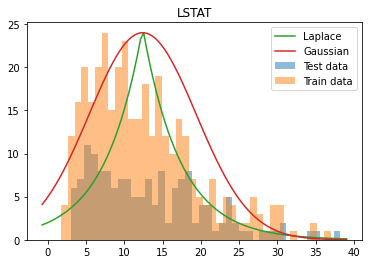

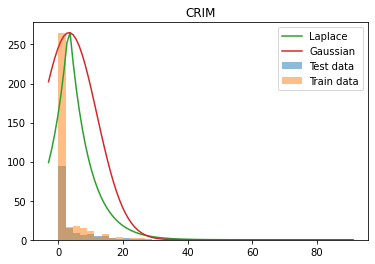

In [16]:
from scipy.stats import norm
for key in para1_4.keys():
    loc, scale, std = np.mean(train_4[key]), np.std(train_4[key])/sqrt(2), np.std(train_4[key])
    s_lap = np.random.laplace(loc, scale, len(test_4[key])+len(train_4[key]))
    s_gau = np.random.normal(loc, std, len(test_4[key])+len(train_4[key]))
    loc, scale = np.mean(train_4[key]), np.std(train_4[key])/sqrt(2)
    binwidth = (max(train_4[key]) - min(train_4[key]))/40
    plt.hist(test_4[key], bins=np.arange(min(test_4[key]), max(test_4[key]) + binwidth, binwidth), label = 'Test data', alpha = 0.5)
    n, bins, patches = plt.hist(train_4[key], bins=np.arange(min(train_4[key]), max(train_4[key]) + binwidth, binwidth), label = 'Train data', alpha = 0.5)
    x = np.arange(min(train_4[key])-scale/2, max(train_4[key])+scale/2, (max(train_4[key])- min(train_4[key])+scale)/100)
    pdf_lap = np.exp(-abs(x-loc)/scale)/(2.*scale)
    pdf_gau = np.exp(-((x-loc)**2 / (2 * std**2 )))/(sqrt(2 * pi) * std)

    pdf_lap *= max(s_lap)/max(pdf_lap)
    pdf_gau *= max(s_gau)/max(pdf_gau)

    plt.plot(x, pdf_lap*(n[n.argmax()])/max(pdf_lap) , label = 'Laplace')
    plt.plot(x, pdf_gau*(n[n.argmax()])/max(pdf_gau) , label = 'Gaussian')
    plt.legend()
    plt.title(key)
    plt.show()
    

In [17]:
import seaborn as sns 
boston_dataset = load_boston()
df = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)

df['target'] = boston_dataset.target
df['label'] = -1
mean = np.mean(boston_dataset['target'])
for index, data in df.iterrows():
    if data['target'] >= mean:
        df.loc[index, 'label'] = 1 ##1=high 
    else:
        df.loc[index, 'label'] = 0 ##0=low
data = df.drop(columns='target')
test = data.sample(frac = 0.3, random_state = random_seed)
train = data.drop(test.index, axis=0)
test.reset_index(inplace=True, drop=True)
train.reset_index(inplace=True, drop=True)


In [18]:
col = train.pop("label")
train.insert(0, col.name, col)

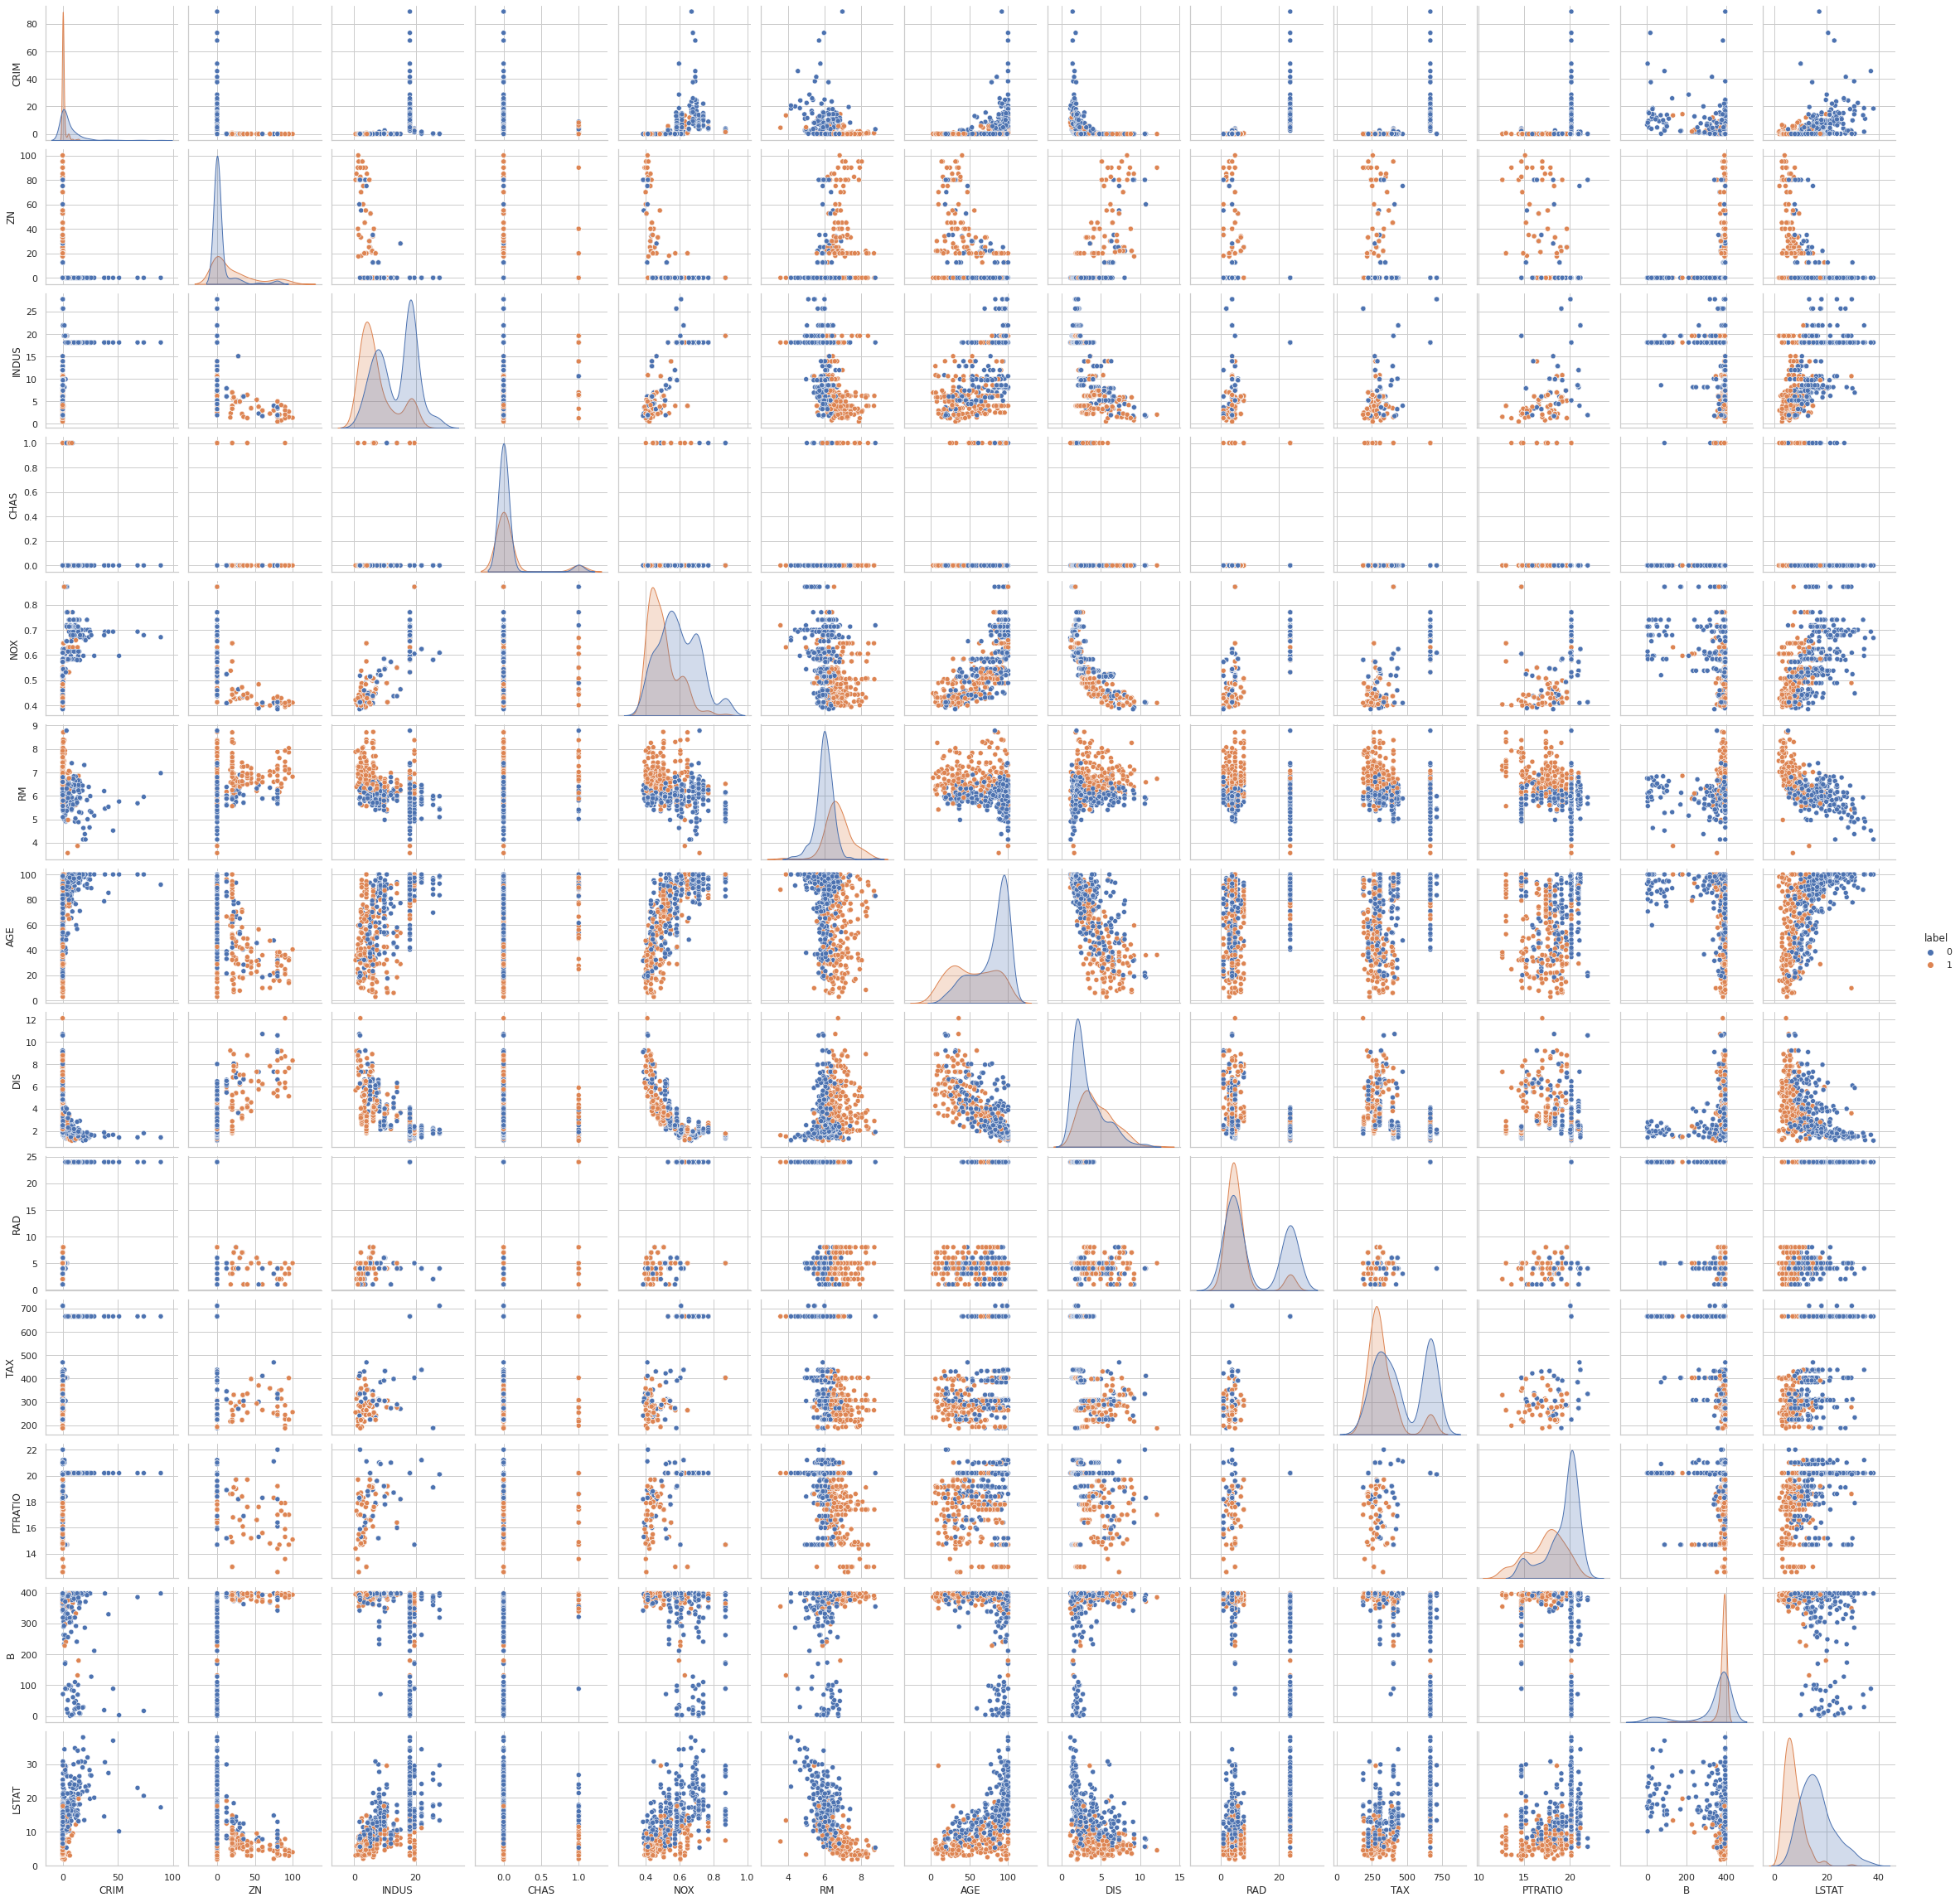

In [19]:
#Pairwise Join Distributions#
sns.set(style = 'whitegrid', context = 'notebook')

sns.pairplot(df, vars = train.columns[1 :], hue = 'label', height = 2.5)


In [20]:
plt.tight_layout()

#if not os.path.exists('./output'):
#    os.makedirs('./output')
#plt.savefig('./output/fig-wine-scatter.png', dpi = 300)
plt.show()

<Figure size 432x288 with 0 Axes>